# Downstream Training 

## Load Ground Truth

In [208]:
import csv
from tqdm import tqdm

label_dict = {}
with open("ComParE2017_Cold_4students/lab/ComParE2017_Cold.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    rows = list(reader)
    for row in tqdm(rows, desc="Loading labels"):
        label_dict[row["file_name"]] = row["Cold (upper respiratory tract infection)"]


Loading labels: 100%|██████████| 19101/19101 [00:00<00:00, 3182971.82it/s]


## Import Sound Model from Huggingface

### Wav2vec
Huggingface: https://huggingface.co/facebook/wav2vec2-base-960h

In [210]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [212]:
from transformers import AutoProcessor, Wav2Vec2Model, Wav2Vec2Config
import torch

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")

model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

Test Model


In [ ]:
!pip install librosa


In [214]:
import librosa

input_file = "./ppl_dataset/val/train_9502.wav"
waveform, sr = librosa.load(input_file, sr=16000)  

inputs = processor(waveform, sampling_rate=16000, return_tensors="pt")

inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs).last_hidden_state.mean(dim=1) 

print(outputs.shape)  




torch.Size([1, 768])


### Whisper
Huggingface: https://huggingface.co/openai/whisper-small

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="openai/whisper-small")

In [ ]:
import torch
from transformers import WhisperProcessor, WhisperModel

processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperModel.from_pretrained("openai/whisper-small")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

## Generating Embeddings

In [260]:
import os
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_root = "ComParE2017_Cold_4students/wav/"
output_root = "embeddings/"
data_dir = "processed_files"

config    = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-base-960h",
                                           output_hidden_states=True)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h", config= config).to(device).eval()

for split in ["train_files", "devel_files", "test_files"]:
    input_dir = os.path.join(input_root, split, data_dir)
    output_dir = os.path.join(output_root, split)
    os.makedirs(output_dir, exist_ok=True)

    wav_files = [f for f in os.listdir(input_dir) if f.endswith(".wav")]
    print(f"[{split}] Found {len(wav_files)} wav files")

    for filename in tqdm(wav_files, desc=f"Processing {split}"):
        wav_path = os.path.join(input_dir, filename)

        waveform, sr = librosa.load(wav_path, sr=16000)

        inputs = processor(waveform, sampling_rate=16000, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            out = model(**inputs)
            hs = out.hidden_states  

        last_k = hs[4:6]  
        pooled = []
        for layer in last_k:
            # layer: [1, T, 768]
            m = layer.mean(dim=1)   # [1,768]
            #s = layer.std(dim=1)    # [1,768]
            mx= layer.max(dim=1).values  # [1,768]
            #mn = layer.min(dim=1).values
            pooled.append(m)
            #pooled.append(s)
            pooled.append(mx)
            #pooled.append(mn)

        feat = torch.cat(pooled, dim=-1)  
        np_feat = feat.cpu().numpy().squeeze()

        save_path = os.path.join(output_dir, filename.replace(".wav", ".npy"))
        np.save(save_path, np_feat)


Using device: cuda


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[train_files] Found 9505 wav files


Processing train_files: 100%|██████████| 9505/9505 [19:46<00:00,  8.01it/s]


[devel_files] Found 9596 wav files


Processing devel_files: 100%|██████████| 9596/9596 [19:00<00:00,  8.41it/s]


[test_files] Found 9551 wav files


Processing test_files: 100%|██████████| 9551/9551 [18:05<00:00,  8.80it/s]


In [261]:
# Print one example
import numpy as np
example_file = "embeddings_original/train_files/train_9502.npy"
embedding = np.load(example_file)
print(f"Embedding shape for {example_file}: {embedding.shape}")
# Print itself
print(f"Embedding for {example_file}: {embedding}")

Embedding shape for embeddings_original/train_files/train_9502.npy: (9216,)
Embedding for embeddings_original/train_files/train_9502.npy: [0.03504366 0.07298383 0.05849733 ... 0.42950696 0.3302093  0.37711555]


In [262]:
config    = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-base-960h",
                                           output_hidden_states=True)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h", config= config).to(device).eval()

out = model(**inputs)
hs = out.hidden_states 
len(hs)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


13

## Load Embeddings

In [263]:
from concurrent.futures import ThreadPoolExecutor
import glob


def load_single_acoustic_embedding(npy_file):
    basename = os.path.splitext(os.path.basename(npy_file))[0]  
    embedding = np.load(npy_file)
    return basename, embedding

def load_acoustic_embeddings(embedding_dir: str):
    npy_files = glob.glob(os.path.join(embedding_dir, "*.npy"))

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(load_single_acoustic_embedding, npy_files),
                            total=len(npy_files),
                            desc="Loading acoustic embeddings"))

    embedding_dict = dict(results)
    print(f"✅ Loaded {len(embedding_dict)} embeddings.")
    print(f"🧪 Sample shape: {next(iter(embedding_dict.values())).shape}")
    return embedding_dict

In [264]:
import os
import numpy as np
from tqdm import tqdm
embedding_dir = "embeddings/"
val_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "devel_files"))
test_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "devel_files"))
train_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "train_files"))

Loading acoustic embeddings: 100%|██████████| 9596/9596 [00:05<00:00, 1840.23it/s]


✅ Loaded 9596 embeddings.
🧪 Sample shape: (3072,)


Loading acoustic embeddings: 100%|██████████| 9596/9596 [00:01<00:00, 6354.70it/s]


✅ Loaded 9596 embeddings.
🧪 Sample shape: (3072,)


Loading acoustic embeddings: 100%|██████████| 9505/9505 [00:05<00:00, 1759.67it/s]


✅ Loaded 9505 embeddings.
🧪 Sample shape: (3072,)


## test

In [299]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

keys = list(train_embeddings_dict.keys())
X_all = np.stack([train_embeddings_dict[k] for k in keys], axis=0)

X, y = [], []
raw_labels = []  

for k, vec in zip(keys, X_all):
    wav = f"{k}.wav"
    if wav in label_dict:
        raw_label = label_dict[wav]
        numeric_label = 1 if raw_label == "C" else 0  # C=Cold=1, 其他=Healthy=0
        
        X.append(vec)
        y.append(numeric_label)
        raw_labels.append(raw_label)

X = np.stack(X, axis=0) 
y = np.array(y)          


In [298]:
print("\n🔄 Analysis Embeddings")

# PCA → 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print(f"PCA: {pca.explained_variance_ratio_}")

pca50 = PCA(n_components=50, random_state=42)
X50 = pca50.fit_transform(X)

print(f"t-SNE input dimension : {X50.shape}")
tsne = TSNE(n_components=2, 
           init="pca", 
           learning_rate="auto", 
           random_state=42,
           perplexity=min(30, len(X)//4),  
           max_iter=1000)
X_tsne = tsne.fit_transform(X50)


🔄 Analysis Embeddings
PCA: [0.13354777 0.04025004]
t-SNE input dimension : (124, 50)


绘制 PCA 2D Projection: 标签类型=<class 'numpy.int64'>, 唯一值=[0 1]
绘制 t-SNE 2D Projection: 标签类型=<class 'numpy.int64'>, 唯一值=[0 1]


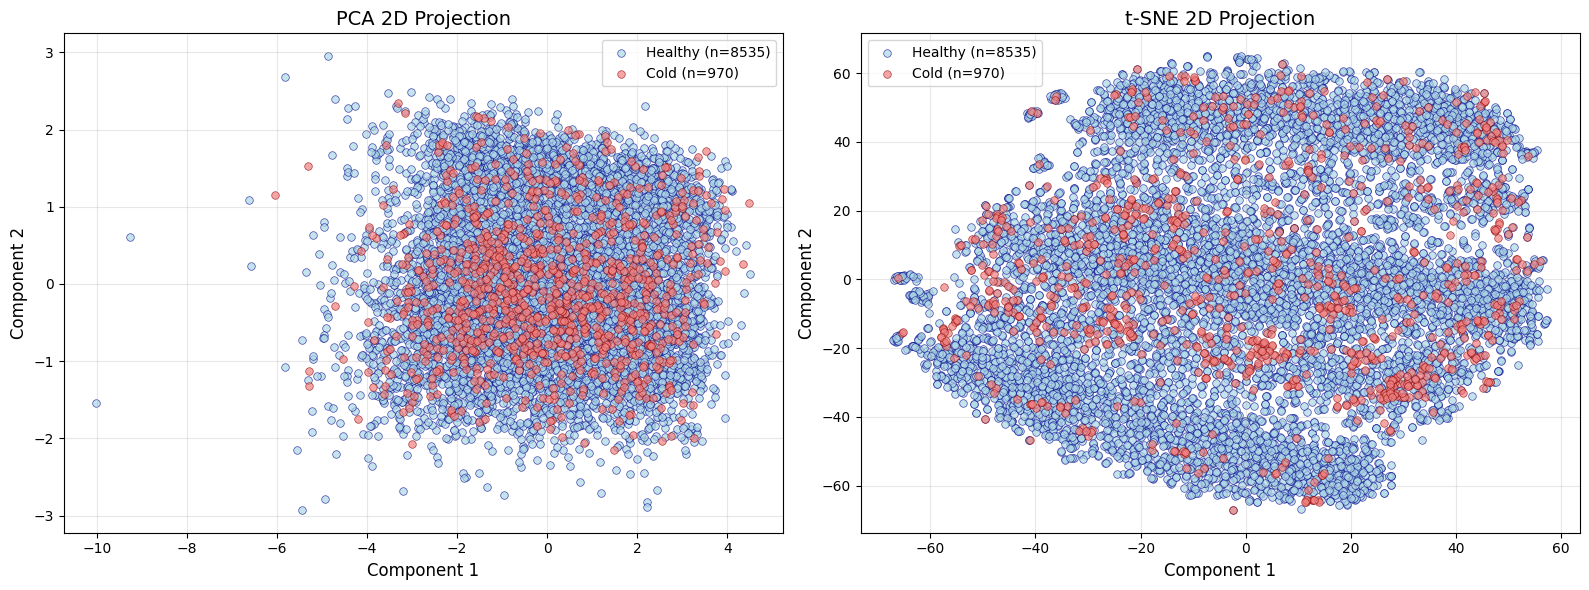

In [ ]:
def plot_2d_enhanced(X2d, y, title, ax=None):
    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
    
    unique_labels = np.unique(y)
    
    if not np.issubdtype(y.dtype, np.number):
        y_numeric = np.array([1 if label == "C" else 0 for label in y])
        y = y_numeric
    
    healthy_mask = (y == 0)
    cold_mask = (y == 1)
    
    if healthy_mask.sum() > 0:
        ax.scatter(X2d[healthy_mask, 0], X2d[healthy_mask, 1],
                  c="lightblue", label=f"Healthy (n={healthy_mask.sum()})", 
                  s=30, alpha=0.7, edgecolors='darkblue', linewidth=0.5)
    
    if cold_mask.sum() > 0:
        ax.scatter(X2d[cold_mask, 0], X2d[cold_mask, 1],
                  c="lightcoral", label=f"Cold (n={cold_mask.sum()})", 
                  s=30, alpha=0.7, edgecolors='darkred', linewidth=0.5)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Component 1", fontsize=12)
    ax.set_ylabel("Component 2", fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_2d_enhanced(X_pca, y, "PCA 2D Projection", axes[0])

plot_2d_enhanced(X_tsne, y, "t-SNE 2D Projection", axes[1])

plt.tight_layout()
plt.show()

In [270]:
# 5. 量化分离度分析
def calculate_separability_metrics(embeddings_2d, labels):
    """计算类别间的分离度指标"""
    healthy_points = embeddings_2d[labels == 0]
    cold_points = embeddings_2d[labels == 1]
    
    if len(healthy_points) == 0 or len(cold_points) == 0:
        print("⚠️ 警告: 某个类别没有样本")
        return None
    
    # 计算类内距离(越小越好)
    healthy_center = healthy_points.mean(axis=0)
    cold_center = cold_points.mean(axis=0)
    
    healthy_intra_dist = np.mean(np.linalg.norm(healthy_points - healthy_center, axis=1))
    cold_intra_dist = np.mean(np.linalg.norm(cold_points - cold_center, axis=1))
    avg_intra_dist = (healthy_intra_dist + cold_intra_dist) / 2
    
    # 计算类间距离(越大越好)
    inter_dist = np.linalg.norm(healthy_center - cold_center)
    
    # 分离度比例 (越大越好)
    separability_ratio = inter_dist / avg_intra_dist if avg_intra_dist > 0 else 0
    
    return {
        'inter_class_distance': inter_dist,
        'avg_intra_class_distance': avg_intra_dist,
        'separability_ratio': separability_ratio,
        'healthy_center': healthy_center,
        'cold_center': cold_center,
        'healthy_samples': len(healthy_points),
        'cold_samples': len(cold_points)
    }

# 计算PCA和t-SNE的分离度
print("\n📊 类别分离度分析:")
print("="*50)

pca_metrics = calculate_separability_metrics(X_pca, y)
if pca_metrics:
    print("PCA结果:")
    print(f"   样本分布: Healthy={pca_metrics['healthy_samples']}, Cold={pca_metrics['cold_samples']}")
    print(f"   类间距离: {pca_metrics['inter_class_distance']:.3f}")
    print(f"   平均类内距离: {pca_metrics['avg_intra_class_distance']:.3f}")
    print(f"   分离度比例: {pca_metrics['separability_ratio']:.3f}")

tsne_metrics = calculate_separability_metrics(X_tsne, y)
if tsne_metrics:
    print("\nt-SNE结果:")
    print(f"   样本分布: Healthy={tsne_metrics['healthy_samples']}, Cold={tsne_metrics['cold_samples']}")
    print(f"   类间距离: {tsne_metrics['inter_class_distance']:.3f}")
    print(f"   平均类内距离: {tsne_metrics['avg_intra_class_distance']:.3f}")
    print(f"   分离度比例: {tsne_metrics['separability_ratio']:.3f}")

# 🎯 可分性评估
print("\n🎯 可分性评估:")
for method, metrics in [("PCA", pca_metrics), ("t-SNE", tsne_metrics)]:
    if metrics:
        ratio = metrics['separability_ratio']
        if ratio > 1.5:
            print(f"✅ {method}: 类别具有良好的可分性 (比例={ratio:.3f})")
        elif ratio > 1.0:
            print(f"⚠️ {method}: 类别具有中等可分性 (比例={ratio:.3f})")
        else:
            print(f"❌ {method}: 类别可分性较差 (比例={ratio:.3f})")

# 💡 结论
if pca_metrics and tsne_metrics:
    max_ratio = max(pca_metrics['separability_ratio'], tsne_metrics['separability_ratio'])
    print(f"\n💡 总体结论:")
    if max_ratio < 1.2:
        print("❌ Cold/Healthy embedding 可分性较差，建议:")
        print("   • 尝试其他预训练模型")
        print("   • 使用更复杂的特征提取")
        print("   • 增加数据增强")
    elif max_ratio > 1.5:
        print("✅ Cold/Healthy embedding 具有一定可分性")
        print("   • 可以继续优化分类器")
    else:
        print("⚠️ Cold/Healthy embedding 可分性中等")
        print("   • 需要进一步特征工程")


📊 类别分离度分析:
PCA结果:
   样本分布: Healthy=8535, Cold=970
   类间距离: 0.084
   平均类内距离: 1.856
   分离度比例: 0.045

t-SNE结果:
   样本分布: Healthy=8535, Cold=970
   类间距离: 1.599
   平均类内距离: 39.918
   分离度比例: 0.040

🎯 可分性评估:
❌ PCA: 类别可分性较差 (比例=0.045)
❌ t-SNE: 类别可分性较差 (比例=0.040)

💡 总体结论:
❌ Cold/Healthy embedding 可分性较差，建议:
   • 尝试其他预训练模型
   • 使用更复杂的特征提取
   • 增加数据增强


## Search in Ground Truth


In [226]:
def search_in_ground_truth(file_id: str, label_dict: dict) -> str:
    wav_name = file_id + ".wav"
    return label_dict.get(wav_name, None)


Test

In [227]:
label = search_in_ground_truth("train_9493", label_dict)
print(label)  


C


## Downstream Network

In [228]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [229]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### FCN

In [ ]:
import torch
import torch.nn as nn

class ColdPredictor(nn.Module):
    def __init__(self, input_size=768, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)   #
        self.bn1   = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)     

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)  
        self.bn2   = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)    

        conv_out = 64 * (input_size // 4)

        self.fc1 = nn.Linear(conv_out, 256)   
        self.bn3 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(256, 128)      
        self.bn4 = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(dropout)

        self.out = nn.Linear(128, 1)

    def forward(self, x):
        x = x.unsqueeze(1)            # [B,1,768]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = x.flatten(1)             

        x = torch.relu(self.bn3(self.fc1(x)))
        x = self.drop1(x)
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.drop2(x)

        return self.out(x)            # [B,1]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock1D(nn.Module):
    def __init__(self, channels, kernel_size=3, dropout=0.1):
        super().__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.bn1   = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.bn2   = nn.BatchNorm1d(channels)
        self.drop  = nn.Dropout(dropout)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.drop(out)
        return F.relu(out + identity)  

class ColdPredictorResNet(nn.Module):
    def __init__(self, input_size=768, base_channels=32, num_blocks=2, dropout=0.3):
        super().__init__()
        self.conv_in = nn.Conv1d(1, base_channels, kernel_size=7, padding=3)
        self.bn_in   = nn.BatchNorm1d(base_channels)
        self.pool_in = nn.MaxPool1d(2)       # 768 -> 384

        self.res_blocks = nn.Sequential(*[
            ResidualBlock1D(base_channels, kernel_size=5, dropout=dropout)
            for _ in range(num_blocks)
        ])

        self.pool_mid = nn.MaxPool1d(2)      # 384 -> 192

        self.global_pool = nn.AdaptiveAvgPool1d(1)  # [B, C, 192] -> [B, C, 1]
        self.fc = nn.Sequential(
            nn.Flatten(),                # [B, C]
            nn.Dropout(dropout),
            nn.Linear(base_channels, 1) 
        )

    def forward(self, x):
        # x: [B, 768]
        x = x.unsqueeze(1)  # [B,1,768]
        x = F.relu(self.bn_in(self.conv_in(x)))
        x = self.pool_in(x)

        x = self.res_blocks(x)
        x = self.pool_mid(x)

        x = self.global_pool(x)  # [B, C, 1]
        x = self.fc(x)           # [B,1]
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets.float(), reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

class SimpleColdPredictor(nn.Module):
    def __init__(self, input_size=9216, dropout=0.3):
        super().__init__()
        
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)  
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = self.global_pool(x) 
        x = x.squeeze(-1)        
        
        return self.classifier(x)

## Training

In [303]:
model = ColdPredictor(input_size=3072).to("cuda" if torch.cuda.is_available() else "cpu")
# model = ColdPredictorResNet(input_size=9216, base_channels=32, num_blocks=2, dropout=0.3)
# model = SimpleColdPredictor(input_size=768, dropout=0.3).to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.5)) # Adjust weights for class imbalance
# criterion = SimpleFocalLoss(alpha=0.25, gamma=0.25)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

device = next(model.parameters()).device
threshold = 0.56  # Threshold for binary classification
# ✅ Training Loop
num_epochs = 150

### Data Loader


In [273]:
from torch.utils.data import Dataset
import torch
import random

class ColdDetectionDataset(Dataset):
    def __init__(self,
                 embedding_dict: dict,
                 label_dict: dict,
                 clusters_txt: str = None,
                 samples_per_cluster=100,
                 label_probs=(0.7, 0.3),
                 cluster_sampling=True):
        
        import numpy as np
        
        self.clusters = {}
        if clusters_txt and os.path.exists(clusters_txt):
            with open(clusters_txt, 'r', encoding='utf-8') as f:
                current_cluster_id = 0
                
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    
                    if line.startswith("Cluster") and "(" in line:
                        try:
                            parts = line.split()
                            current_cluster_id = int(parts[1])
                        except (IndexError, ValueError) as e:
                            print(f"⚠️ Warning: Could not parse cluster header: {line}")
                            continue
                    
                    elif line.endswith('.wav'):
                        base_name = os.path.splitext(line)[0]
                        self.clusters[base_name] = current_cluster_id
        
        if self.clusters:
            from collections import Counter
            cluster_counts = Counter(self.clusters.values())
            print(f"✅ Parsed {len(self.clusters)} files into {len(cluster_counts)} clusters")
            print(f"📊 Cluster distribution: {dict(sorted(cluster_counts.items()))}")
        else:
            print("❌ No clusters were parsed from the file")
        
        self.cluster_sampling = cluster_sampling and bool(self.clusters)
        self.samples_per_cluster = samples_per_cluster
        
        self.data_map = {}  # {cluster_id: {label: [samples]}}
        self.all_samples = []
        
        for file_id, emb in embedding_dict.items():
            label_key = f"{file_id}.wav"
            if label_key not in label_dict:
                continue
                
            raw_label = label_dict[label_key]
            lab = 1 if raw_label == "C" else 0
            
            cid = self.clusters.get(file_id, 0) if self.cluster_sampling else 0
            
            sample = (
                file_id,
                torch.tensor(emb, dtype=torch.float32),
                torch.tensor(lab, dtype=torch.long),
                torch.tensor(cid, dtype=torch.long)
            )
            
            if cid not in self.data_map:
                self.data_map[cid] = {}
            if lab not in self.data_map[cid]:
                self.data_map[cid][lab] = []
            
            self.data_map[cid][lab].append(sample)
            self.all_samples.append(sample)
        
        self.available_labels = sorted(set(
            lab for cluster_data in self.data_map.values() 
            for lab in cluster_data.keys()
        ))
        
        self.label_probs = np.array(label_probs[:len(self.available_labels)])
        self.label_probs = self.label_probs / self.label_probs.sum()
        
        if self.cluster_sampling:
            self.create_balanced_cold_dataset()
        else:
            self.epoch_samples = self.all_samples.copy()
        
        print(f"✅ Dataset initialized:")
        print(f"   - Total samples: {len(self.all_samples)}")
        print(f"   - Epoch samples: {len(self.epoch_samples)}")
        print(f"   - Clusters: {len(self.data_map)}")
        print(f"   - Samples per cluster limit: {self.samples_per_cluster}")
        
    def _create_epoch_samples(self):
        self.epoch_samples = []
        
        for cid, cluster_data in self.data_map.items():
            total_cluster_samples = sum(len(samples) for samples in cluster_data.values())
            target_cluster_samples = min(total_cluster_samples, self.samples_per_cluster)
            
            if target_cluster_samples == 0:
                continue
            
            cluster_epoch_samples = []
            
            for i, lab in enumerate(self.available_labels):
                if lab not in cluster_data:
                    continue
                
                target_label_samples = int(target_cluster_samples * self.label_probs[i])
                available_label_samples = len(cluster_data[lab])
                
                actual_label_samples = min(target_label_samples, available_label_samples)
                
                if actual_label_samples > 0:
                    if actual_label_samples == available_label_samples:
                        selected_samples = cluster_data[lab]
                    else:
                        import random
                        selected_samples = random.sample(cluster_data[lab], actual_label_samples)
                    
                    cluster_epoch_samples.extend(selected_samples)
            
            current_count = len(cluster_epoch_samples)
            if current_count < target_cluster_samples:
                remaining_needed = target_cluster_samples - current_count
                
                used_samples = set(id(s) for s in cluster_epoch_samples)
                all_cluster_samples = []
                for lab_samples in cluster_data.values():
                    for sample in lab_samples:
                        if id(sample) not in used_samples:
                            all_cluster_samples.append(sample)
                
                if all_cluster_samples and remaining_needed > 0:
                    import random
                    additional_count = min(remaining_needed, len(all_cluster_samples))
                    additional_samples = random.sample(all_cluster_samples, additional_count)
                    cluster_epoch_samples.extend(additional_samples)
            
            self.epoch_samples.extend(cluster_epoch_samples)
        
        random.shuffle(self.epoch_samples)
        
        print(f"📊 Epoch samples created: {len(self.epoch_samples)} samples")
        
        cluster_counts = {}
        label_counts = {lab: 0 for lab in self.available_labels}
        
        for sample in self.epoch_samples:
            cid = sample[3].item()  # cluster_id
            lab = sample[2].item()  # label
            cluster_counts[cid] = cluster_counts.get(cid, 0) + 1
            label_counts[lab] += 1
        
        print(f"📊 Samples per cluster: {dict(sorted(cluster_counts.items()))}")
        print(f"📊 Label distribution: {label_counts}")
        
        total_samples = len(self.epoch_samples)
        if total_samples > 0:
            actual_label_probs = {lab: count/total_samples for lab, count in label_counts.items()}
            target_label_probs = {lab: prob for lab, prob in zip(self.available_labels, self.label_probs)}
            print(f"🎯 Target label ratios: {target_label_probs}")
            print(f"📈 Actual label ratios: {actual_label_probs}")
    
    def create_balanced_cold_dataset(self, max_samples_per_class=None):
        samples_by_label = {0: [], 1: []}
        for sample in self.all_samples:
            label = sample[2].item()
            samples_by_label[label].append(sample)
        
        print(f"📊 原始分布: Healthy={len(samples_by_label[0])}, Cold={len(samples_by_label[1])}")
        
        # 🔥 修改策略：取所有正例，然后随机选择同样数量的负例
        num_cold_samples = len(samples_by_label[1])  # 所有Cold样本
        
        if max_samples_per_class is None:
            # 使用所有Cold样本，然后随机选择同样数量的Healthy样本
            samples_per_class = num_cold_samples
            max_healthy_samples = min(num_cold_samples, len(samples_by_label[0]))
        else:
            # 限制每类最大样本数
            samples_per_class = min(max_samples_per_class, num_cold_samples)
            max_healthy_samples = min(samples_per_class, len(samples_by_label[0]))
        
        self.balanced_samples = []
        
        # 添加所有Cold样本（或限制数量）
        if len(samples_by_label[1]) <= samples_per_class:
            cold_samples = samples_by_label[1]
        else:
            cold_samples = random.sample(samples_by_label[1], samples_per_class)
        
        # 随机选择同样数量的Healthy样本
        if len(samples_by_label[0]) <= max_healthy_samples:
            healthy_samples = samples_by_label[0]
        else:
            healthy_samples = random.sample(samples_by_label[0], max_healthy_samples)
        
        self.balanced_samples.extend(cold_samples)
        self.balanced_samples.extend(healthy_samples)
        random.shuffle(self.balanced_samples)
        
        print(f"📊 平衡后分布:")
        print(f"   Cold样本: {len(cold_samples)}")
        print(f"   Healthy样本: {len(healthy_samples)}")
        print(f"   总计: {len(self.balanced_samples)}")
        
        # 🔧 修复：保持原有的4元组结构
        self.epoch_samples = self.balanced_samples.copy()

    def __getitem__(self, idx):
        # 🔧 修复：正确处理不同的数据结构
        sample = self.epoch_samples[idx]
        
        if len(sample) == 4:
            # 原始格式：(file_id, embedding, label, cluster_id)
            file_id, embedding, label, cluster_id = sample
            return embedding, label
        elif len(sample) == 3:
            # 新格式：(file_id, embedding, label)
            file_id, embedding, label = sample
            return embedding, label
        else:
            raise ValueError(f"Unexpected sample format with {len(sample)} elements")
        
    
    def __len__(self):
        return len(self.epoch_samples)
    
    
    def refresh_epoch_samples_balanced(self):
        if self.cluster_sampling:
            self.create_balanced_cold_dataset()
    
    def refresh_epoch_samples(self):
        if self.cluster_sampling:
            self._create_epoch_samples()
    
    def get_statistics(self):
        stats = {
            'total_samples': len(self.all_samples),
            'epoch_samples': len(self.epoch_samples),
            'num_clusters': len(self.data_map),
            'cluster_details': {}
        }
        
        for cid, cluster_data in self.data_map.items():
            total_in_cluster = sum(len(samples) for samples in cluster_data.values())
            stats['cluster_details'][cid] = {
                'total': total_in_cluster,
                'by_label': {lab: len(samples) for lab, samples in cluster_data.items()}
            }
        
        return stats

### Data Loader without Cluster

In [274]:
from torch.utils.data import Dataset
import torch
import random

class ColdDetectionDataset(Dataset):
    def __init__(self,
                 embedding_dict: dict,
                 label_dict: dict,
                 label_ratio = 2,
                ):
        
        self.data_map = {} 
        self.all_samples = []
        
        for file_id, emb in embedding_dict.items():
            label_key = f"{file_id}.wav"
            if label_key not in label_dict:
                continue
                
            raw_label = label_dict[label_key]
            lab = 1 if raw_label == "C" else 0
            
            sample = (
                file_id,
                torch.tensor(emb, dtype=torch.float32),
                torch.tensor(lab, dtype=torch.long),
            ) 
            self.all_samples.append(sample)
        
        self.create_balanced_cold_dataset( label_ratio)

        
    
    def create_balanced_cold_dataset(self, label_ratio):
        samples_by_label = {0: [], 1: []}
        for sample in self.all_samples:
            label = sample[2].item()
            samples_by_label[label].append(sample)
                        
        num_healthy_samples = min(len(samples_by_label[1])*label_ratio, len(samples_by_label[0]))     
        self.balanced_samples = []
        
        for sample in samples_by_label[1]:
            self.balanced_samples.append(sample)
        
        healthy_samples = random.sample(samples_by_label[0], num_healthy_samples)
        self.balanced_samples.extend(healthy_samples)

        random.shuffle(self.balanced_samples)
        self.epoch_samples = self.balanced_samples.copy()

    def __getitem__(self, idx):
        sample = self.epoch_samples[idx]
        
        if len(sample) == 3:
            file_id, embedding, label = sample
            return embedding, label
        else:
            raise ValueError(f"Unexpected sample format with {len(sample)} elements")
        
    
    def __len__(self):
        return len(self.epoch_samples)
    
    
    def refresh_epoch_samples_balanced(self, label_ratio):
        self.create_balanced_cold_dataset(label_ratio)
    
    def get_statistics(self):
        stats = {
            'total_samples': len(self.all_samples),
            'epoch_samples': len(self.epoch_samples),
        }
        
        return stats

### Test DL

In [275]:
from torch.utils.data import DataLoader

clusters_txt = "./clusters_8.txt"
train_dataset = ColdDetectionDataset(
                    train_embeddings_dict, 
                    label_dict,
                    clusters_txt,
                    samples_per_cluster= 300,
                    label_probs=(0.5, 0.5),
                    cluster_sampling=True
                )
val_dataset = ColdDetectionDataset(
                    val_embeddings_dict, 
                    label_dict,
                    clusters_txt,
                    samples_per_cluster= 500,
                    label_probs=(0.5, 0.5),
                    cluster_sampling=True
                )

training_params = {
    'batch_size': 32,
    'num_workers': 0  
}

train_loader = DataLoader(
    train_dataset,
    batch_size=training_params['batch_size'],
    shuffle=True,
    num_workers=training_params['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=training_params['batch_size'],
    shuffle=False,
    num_workers=training_params['num_workers'],
    pin_memory=True
)


TypeError: ColdDetectionDataset.__init__() got an unexpected keyword argument 'samples_per_cluster'

In [ ]:
from collections import Counter
import torch

def inspect_loader(loader, num_batches=3):
    print(f"Inspecting {num_batches} batches from loader…")
    for i, batch in enumerate(loader):
        # 🔧 修正：您的 __getitem__ 只返回 (embedding, label)
        X, y = batch  
        print(f"\nBatch {i+1}")
        print(f"  • X.shape:   {X.shape}   # (batch, feat_dim)")
        print(f"  • y.shape:   {y.shape}, labels freq: {dict(Counter(y.tolist()))}")
        
        # 🔍 额外检查数据范围
        print(f"  • X range:   min={X.min():.4f}, max={X.max():.4f}, mean={X.mean():.4f}")
        print(f"  • y values:  min={y.min()}, max={y.max()}")
        
        if i+1 >= num_batches:
            break

# 🔍 额外添加数据集整体统计
def inspect_dataset_stats(dataset):
    print(f"\n📊 Dataset Statistics:")
    print(f"  • Total samples: {len(dataset)}")
    
    # 检查前几个样本
    all_labels = []
    for i in range(min(100, len(dataset))):  # 只检查前100个样本避免太慢
        _, label = dataset[i]
        all_labels.append(label.item())
    
    label_dist = Counter(all_labels)
    print(f"  • Label distribution (first 100): {dict(label_dist)}")
    
    # 检查embedding形状
    sample_emb, sample_label = dataset[0]
    print(f"  • Embedding shape: {sample_emb.shape}")
    print(f"  • Embedding dtype: {sample_emb.dtype}")
    print(f"  • Label dtype: {sample_label.dtype}")

# 用法
print("🔍 Training Dataset:")
inspect_dataset_stats(train_dataset)
inspect_loader(train_loader)

print("\n🔍 Validation Dataset:")
inspect_dataset_stats(val_dataset)
inspect_loader(val_loader)

🔍 Training Dataset:

📊 Dataset Statistics:
  • Total samples: 2400
  • Label distribution (first 100): {0: 60, 1: 40}
  • Embedding shape: torch.Size([768])
  • Embedding dtype: torch.float32
  • Label dtype: torch.int64
Inspecting 3 batches from loader…

Batch 1
  • X.shape:   torch.Size([32, 768])   # (batch, feat_dim)
  • y.shape:   torch.Size([32]), labels freq: {0: 21, 1: 11}
  • X range:   min=-1.4091, max=1.1297, mean=-0.0013
  • y values:  min=0, max=1

Batch 2
  • X.shape:   torch.Size([32, 768])   # (batch, feat_dim)
  • y.shape:   torch.Size([32]), labels freq: {0: 19, 1: 13}
  • X range:   min=-1.3287, max=0.9715, mean=-0.0013
  • y values:  min=0, max=1

Batch 3
  • X.shape:   torch.Size([32, 768])   # (batch, feat_dim)
  • y.shape:   torch.Size([32]), labels freq: {1: 10, 0: 22}
  • X range:   min=-1.2422, max=0.9848, mean=-0.0013
  • y values:  min=0, max=1

🔍 Validation Dataset:

📊 Dataset Statistics:
  • Total samples: 500
  • Label distribution (first 100): {1: 44, 0:

### Training Loop


In [304]:
import time
from sklearn.metrics import accuracy_score, f1_score

label_ratio = 2 
train_dataset = ColdDetectionDataset(
    train_embeddings_dict, 
    label_dict,
    label_ratio=3,
)
val_dataset = ColdDetectionDataset(
    val_embeddings_dict, 
    label_dict,
    label_ratio=5,
)

best_val_loss = float('inf')
patience = 100
patience_counter = 0
training_losses = []
validation_losses = []
start_time = time.time()

print("Starting training...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    print(f'\n{"="*80}')
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'{"="*80}\n')
    
   
    """
    if epoch >  70:
        train_dataset = ColdDetectionDataset(
            train_embeddings_dict, 
            label_dict,
            label_ratio=10
        )
        val_dataset = ColdDetectionDataset(
            val_embeddings_dict, 
            label_dict,
            label_ratio=10
        )
    """
    if epoch > 0:  
        print("🔄 Refreshing training samples...")
        train_dataset.create_balanced_cold_dataset(label_ratio=label_ratio)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        drop_last=True  
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=256,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        drop_last=False
    )

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")

    for batch_X, batch_y in progress_bar:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Forward
        optimizer.zero_grad()
        logits = model(batch_X).squeeze()
        loss = criterion(logits, batch_y.float())

        # Backward
        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(logits) > threshold).long()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

        running_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(train_loader)
    training_losses.append(epoch_loss)
    
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds)


    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []

    with torch.no_grad():
        for batch_X, batch_y in tqdm(val_loader, desc="Validating"):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X).squeeze()
            loss = criterion(logits, batch_y.float())
            val_loss += loss.item()

            preds = (torch.sigmoid(logits) > threshold).long()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch_y.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)
    
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    print(f"\nEpoch [{epoch+1}] Summary:")
    print(f"  📈 Training   - Loss: {epoch_loss:.4f}, Acc: {train_accuracy:.4f}, F1: {train_f1:.4f}")
    print(f"  📊 Validation - Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}")
    print(f"  📦 Processed  - Train: {len(all_labels)} samples, Val: {len(val_labels)} samples")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_cold_model.pth")
        print("  ✅ Saved best model")
    else:
        patience_counter += 1
        print(f"  ⏳ Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"\n⛔ Early stopping triggered at epoch {epoch+1}")
            break

print(f"\n🎉 Training complete in {(time.time() - start_time)/60:.2f} min")
print(f"📊 Best validation loss: {best_val_loss:.4f}")

Starting training...


Epoch [1/150]



Validating: 100%|██████████| 24/24 [00:00<00:00, 67.04it/s]



Epoch [1] Summary:
  📈 Training   - Loss: 0.9625, Acc: 0.6763, F1: 0.2462
  📊 Validation - Loss: 0.8366, Acc: 0.8332, F1: 0.0000
  📦 Processed  - Train: 3840 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [2/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.96it/s]



Epoch [2] Summary:
  📈 Training   - Loss: 1.0256, Acc: 0.6609, F1: 0.3472
  📊 Validation - Loss: 0.8422, Acc: 0.7860, F1: 0.1427
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [3/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.23it/s]



Epoch [3] Summary:
  📈 Training   - Loss: 1.0028, Acc: 0.6751, F1: 0.3822
  📊 Validation - Loss: 0.8430, Acc: 0.7600, F1: 0.2272
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [4/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.51it/s]



Epoch [4] Summary:
  📈 Training   - Loss: 0.9804, Acc: 0.6889, F1: 0.4176
  📊 Validation - Loss: 0.8334, Acc: 0.7631, F1: 0.2520
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [5/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.77it/s]



Epoch [5] Summary:
  📈 Training   - Loss: 0.9411, Acc: 0.7042, F1: 0.4580
  📊 Validation - Loss: 0.8301, Acc: 0.7593, F1: 0.2829
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [6/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.95it/s]



Epoch [6] Summary:
  📈 Training   - Loss: 0.9274, Acc: 0.7287, F1: 0.5207
  📊 Validation - Loss: 0.8221, Acc: 0.7610, F1: 0.2878
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [7/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.40it/s]



Epoch [7] Summary:
  📈 Training   - Loss: 0.9058, Acc: 0.7337, F1: 0.5404
  📊 Validation - Loss: 0.8116, Acc: 0.7702, F1: 0.2895
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [8/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 67.61it/s]



Epoch [8] Summary:
  📈 Training   - Loss: 0.8828, Acc: 0.7507, F1: 0.5730
  📊 Validation - Loss: 0.8092, Acc: 0.7628, F1: 0.2984
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [9/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.35it/s]



Epoch [9] Summary:
  📈 Training   - Loss: 0.8738, Acc: 0.7493, F1: 0.5798
  📊 Validation - Loss: 0.8019, Acc: 0.7676, F1: 0.3068
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [10/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.71it/s]



Epoch [10] Summary:
  📈 Training   - Loss: 0.8587, Acc: 0.7553, F1: 0.5847
  📊 Validation - Loss: 0.7959, Acc: 0.7710, F1: 0.3100
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [11/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.23it/s]



Epoch [11] Summary:
  📈 Training   - Loss: 0.8467, Acc: 0.7635, F1: 0.6064
  📊 Validation - Loss: 0.7966, Acc: 0.7677, F1: 0.3183
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [12/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.07it/s]



Epoch [12] Summary:
  📈 Training   - Loss: 0.8310, Acc: 0.7702, F1: 0.6227
  📊 Validation - Loss: 0.7903, Acc: 0.7745, F1: 0.3221
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [13/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.53it/s]



Epoch [13] Summary:
  📈 Training   - Loss: 0.8174, Acc: 0.7802, F1: 0.6469
  📊 Validation - Loss: 0.7897, Acc: 0.7715, F1: 0.3246
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [14/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.17it/s]



Epoch [14] Summary:
  📈 Training   - Loss: 0.8011, Acc: 0.7898, F1: 0.6629
  📊 Validation - Loss: 0.7849, Acc: 0.7778, F1: 0.3212
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [15/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.90it/s]



Epoch [15] Summary:
  📈 Training   - Loss: 0.7889, Acc: 0.7947, F1: 0.6701
  📊 Validation - Loss: 0.7850, Acc: 0.7737, F1: 0.3306
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [16/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.61it/s]



Epoch [16] Summary:
  📈 Training   - Loss: 0.7711, Acc: 0.8072, F1: 0.6941
  📊 Validation - Loss: 0.7823, Acc: 0.7742, F1: 0.3317
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [17/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 70.29it/s]



Epoch [17] Summary:
  📈 Training   - Loss: 0.7772, Acc: 0.8047, F1: 0.6948
  📊 Validation - Loss: 0.7825, Acc: 0.7676, F1: 0.3318
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [18/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 71.15it/s]



Epoch [18] Summary:
  📈 Training   - Loss: 0.7508, Acc: 0.8153, F1: 0.7092
  📊 Validation - Loss: 0.7775, Acc: 0.7737, F1: 0.3319
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [19/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 71.43it/s]



Epoch [19] Summary:
  📈 Training   - Loss: 0.7473, Acc: 0.8171, F1: 0.7137
  📊 Validation - Loss: 0.7796, Acc: 0.7687, F1: 0.3341
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [20/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.22it/s]



Epoch [20] Summary:
  📈 Training   - Loss: 0.7373, Acc: 0.8182, F1: 0.7159
  📊 Validation - Loss: 0.7816, Acc: 0.7648, F1: 0.3397
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [21/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.73it/s]



Epoch [21] Summary:
  📈 Training   - Loss: 0.7428, Acc: 0.8178, F1: 0.7210
  📊 Validation - Loss: 0.7774, Acc: 0.7689, F1: 0.3381
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [22/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.23it/s]



Epoch [22] Summary:
  📈 Training   - Loss: 0.7234, Acc: 0.8324, F1: 0.7424
  📊 Validation - Loss: 0.7750, Acc: 0.7699, F1: 0.3390
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [23/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.07it/s]



Epoch [23] Summary:
  📈 Training   - Loss: 0.7046, Acc: 0.8381, F1: 0.7516
  📊 Validation - Loss: 0.7764, Acc: 0.7657, F1: 0.3381
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [24/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 71.53it/s]



Epoch [24] Summary:
  📈 Training   - Loss: 0.7038, Acc: 0.8409, F1: 0.7555
  📊 Validation - Loss: 0.7650, Acc: 0.7824, F1: 0.3340
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [25/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 66.65it/s]



Epoch [25] Summary:
  📈 Training   - Loss: 0.7094, Acc: 0.8338, F1: 0.7497
  📊 Validation - Loss: 0.7680, Acc: 0.7732, F1: 0.3346
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [26/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.41it/s]



Epoch [26] Summary:
  📈 Training   - Loss: 0.6866, Acc: 0.8491, F1: 0.7691
  📊 Validation - Loss: 0.7665, Acc: 0.7761, F1: 0.3356
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [27/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 70.91it/s]



Epoch [27] Summary:
  📈 Training   - Loss: 0.6852, Acc: 0.8505, F1: 0.7728
  📊 Validation - Loss: 0.7690, Acc: 0.7692, F1: 0.3396
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 3/100

Epoch [28/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 70.38it/s]



Epoch [28] Summary:
  📈 Training   - Loss: 0.6757, Acc: 0.8509, F1: 0.7780
  📊 Validation - Loss: 0.7621, Acc: 0.7809, F1: 0.3345
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [29/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 69.42it/s]



Epoch [29] Summary:
  📈 Training   - Loss: 0.6614, Acc: 0.8647, F1: 0.7964
  📊 Validation - Loss: 0.7657, Acc: 0.7778, F1: 0.3405
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [30/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 66.85it/s]



Epoch [30] Summary:
  📈 Training   - Loss: 0.6668, Acc: 0.8484, F1: 0.7730
  📊 Validation - Loss: 0.7637, Acc: 0.7778, F1: 0.3405
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [31/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.62it/s]



Epoch [31] Summary:
  📈 Training   - Loss: 0.6509, Acc: 0.8640, F1: 0.7968
  📊 Validation - Loss: 0.7667, Acc: 0.7705, F1: 0.3415
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 3/100

Epoch [32/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 69.41it/s]



Epoch [32] Summary:
  📈 Training   - Loss: 0.6493, Acc: 0.8622, F1: 0.7971
  📊 Validation - Loss: 0.7648, Acc: 0.7737, F1: 0.3427
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 4/100

Epoch [33/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 58.14it/s]



Epoch [33] Summary:
  📈 Training   - Loss: 0.6430, Acc: 0.8612, F1: 0.7962
  📊 Validation - Loss: 0.7650, Acc: 0.7705, F1: 0.3459
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 5/100

Epoch [34/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.33it/s]



Epoch [34] Summary:
  📈 Training   - Loss: 0.6295, Acc: 0.8714, F1: 0.8074
  📊 Validation - Loss: 0.7607, Acc: 0.7750, F1: 0.3428
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [35/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.28it/s]



Epoch [35] Summary:
  📈 Training   - Loss: 0.6222, Acc: 0.8832, F1: 0.8278
  📊 Validation - Loss: 0.7634, Acc: 0.7728, F1: 0.3419
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [36/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 71.26it/s]



Epoch [36] Summary:
  📈 Training   - Loss: 0.6251, Acc: 0.8803, F1: 0.8249
  📊 Validation - Loss: 0.7660, Acc: 0.7689, F1: 0.3467
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [37/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 71.31it/s]



Epoch [37] Summary:
  📈 Training   - Loss: 0.6237, Acc: 0.8814, F1: 0.8248
  📊 Validation - Loss: 0.7640, Acc: 0.7705, F1: 0.3440
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 3/100

Epoch [38/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.58it/s]



Epoch [38] Summary:
  📈 Training   - Loss: 0.6134, Acc: 0.8846, F1: 0.8313
  📊 Validation - Loss: 0.7632, Acc: 0.7728, F1: 0.3457
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 4/100

Epoch [39/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.39it/s]



Epoch [39] Summary:
  📈 Training   - Loss: 0.6142, Acc: 0.8789, F1: 0.8225
  📊 Validation - Loss: 0.7574, Acc: 0.7798, F1: 0.3445
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [40/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.51it/s]



Epoch [40] Summary:
  📈 Training   - Loss: 0.6069, Acc: 0.8874, F1: 0.8332
  📊 Validation - Loss: 0.7590, Acc: 0.7773, F1: 0.3458
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [41/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.29it/s]



Epoch [41] Summary:
  📈 Training   - Loss: 0.6014, Acc: 0.8835, F1: 0.8308
  📊 Validation - Loss: 0.7595, Acc: 0.7760, F1: 0.3413
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [42/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.12it/s]



Epoch [42] Summary:
  📈 Training   - Loss: 0.5967, Acc: 0.9002, F1: 0.8561
  📊 Validation - Loss: 0.7579, Acc: 0.7773, F1: 0.3458
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 3/100

Epoch [43/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.78it/s]



Epoch [43] Summary:
  📈 Training   - Loss: 0.5866, Acc: 0.8945, F1: 0.8475
  📊 Validation - Loss: 0.7575, Acc: 0.7773, F1: 0.3464
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 4/100

Epoch [44/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.46it/s]



Epoch [44] Summary:
  📈 Training   - Loss: 0.5857, Acc: 0.8960, F1: 0.8492
  📊 Validation - Loss: 0.7587, Acc: 0.7773, F1: 0.3445
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 5/100

Epoch [45/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.77it/s]



Epoch [45] Summary:
  📈 Training   - Loss: 0.5753, Acc: 0.9006, F1: 0.8549
  📊 Validation - Loss: 0.7584, Acc: 0.7760, F1: 0.3469
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 6/100

Epoch [46/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.67it/s]



Epoch [46] Summary:
  📈 Training   - Loss: 0.5711, Acc: 0.9098, F1: 0.8685
  📊 Validation - Loss: 0.7557, Acc: 0.7799, F1: 0.3446
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [47/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.06it/s]



Epoch [47] Summary:
  📈 Training   - Loss: 0.5682, Acc: 0.9002, F1: 0.8576
  📊 Validation - Loss: 0.7583, Acc: 0.7760, F1: 0.3438
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [48/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.76it/s]



Epoch [48] Summary:
  📈 Training   - Loss: 0.5719, Acc: 0.9034, F1: 0.8621
  📊 Validation - Loss: 0.7569, Acc: 0.7753, F1: 0.3419
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [49/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.33it/s]



Epoch [49] Summary:
  📈 Training   - Loss: 0.5612, Acc: 0.9087, F1: 0.8679
  📊 Validation - Loss: 0.7564, Acc: 0.7768, F1: 0.3453
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 3/100

Epoch [50/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.07it/s]



Epoch [50] Summary:
  📈 Training   - Loss: 0.5616, Acc: 0.9119, F1: 0.8739
  📊 Validation - Loss: 0.7491, Acc: 0.7873, F1: 0.3357
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [51/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.51it/s]



Epoch [51] Summary:
  📈 Training   - Loss: 0.5481, Acc: 0.9190, F1: 0.8837
  📊 Validation - Loss: 0.7531, Acc: 0.7819, F1: 0.3415
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [52/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 71.90it/s]



Epoch [52] Summary:
  📈 Training   - Loss: 0.5554, Acc: 0.9094, F1: 0.8713
  📊 Validation - Loss: 0.7510, Acc: 0.7837, F1: 0.3400
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [53/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.53it/s]



Epoch [53] Summary:
  📈 Training   - Loss: 0.5506, Acc: 0.9137, F1: 0.8770
  📊 Validation - Loss: 0.7511, Acc: 0.7832, F1: 0.3422
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 3/100

Epoch [54/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.07it/s]



Epoch [54] Summary:
  📈 Training   - Loss: 0.5402, Acc: 0.9102, F1: 0.8688
  📊 Validation - Loss: 0.7568, Acc: 0.7740, F1: 0.3512
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 4/100

Epoch [55/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.84it/s]



Epoch [55] Summary:
  📈 Training   - Loss: 0.5381, Acc: 0.9187, F1: 0.8845
  📊 Validation - Loss: 0.7545, Acc: 0.7761, F1: 0.3509
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 5/100

Epoch [56/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 71.90it/s]



Epoch [56] Summary:
  📈 Training   - Loss: 0.5321, Acc: 0.9233, F1: 0.8906
  📊 Validation - Loss: 0.7488, Acc: 0.7819, F1: 0.3421
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [57/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 71.86it/s]



Epoch [57] Summary:
  📈 Training   - Loss: 0.5299, Acc: 0.9212, F1: 0.8873
  📊 Validation - Loss: 0.7479, Acc: 0.7847, F1: 0.3411
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [58/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.39it/s]



Epoch [58] Summary:
  📈 Training   - Loss: 0.5267, Acc: 0.9219, F1: 0.8889
  📊 Validation - Loss: 0.7490, Acc: 0.7835, F1: 0.3399
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [59/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.23it/s]



Epoch [59] Summary:
  📈 Training   - Loss: 0.5130, Acc: 0.9414, F1: 0.9158
  📊 Validation - Loss: 0.7518, Acc: 0.7798, F1: 0.3457
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [60/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.47it/s]



Epoch [60] Summary:
  📈 Training   - Loss: 0.5130, Acc: 0.9308, F1: 0.9007
  📊 Validation - Loss: 0.7491, Acc: 0.7832, F1: 0.3428
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 3/100

Epoch [61/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.53it/s]



Epoch [61] Summary:
  📈 Training   - Loss: 0.5130, Acc: 0.9329, F1: 0.9038
  📊 Validation - Loss: 0.7589, Acc: 0.7705, F1: 0.3556
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 4/100

Epoch [62/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.50it/s]



Epoch [62] Summary:
  📈 Training   - Loss: 0.5101, Acc: 0.9311, F1: 0.9003
  📊 Validation - Loss: 0.7523, Acc: 0.7798, F1: 0.3464
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 5/100

Epoch [63/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 67.95it/s]



Epoch [63] Summary:
  📈 Training   - Loss: 0.5076, Acc: 0.9382, F1: 0.9107
  📊 Validation - Loss: 0.7506, Acc: 0.7822, F1: 0.3477
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 6/100

Epoch [64/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.30it/s]



Epoch [64] Summary:
  📈 Training   - Loss: 0.4996, Acc: 0.9318, F1: 0.9040
  📊 Validation - Loss: 0.7517, Acc: 0.7796, F1: 0.3507
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 7/100

Epoch [65/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.05it/s]



Epoch [65] Summary:
  📈 Training   - Loss: 0.4930, Acc: 0.9403, F1: 0.9149
  📊 Validation - Loss: 0.7480, Acc: 0.7857, F1: 0.3461
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 8/100

Epoch [66/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.66it/s]



Epoch [66] Summary:
  📈 Training   - Loss: 0.4892, Acc: 0.9382, F1: 0.9119
  📊 Validation - Loss: 0.7482, Acc: 0.7824, F1: 0.3439
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 9/100

Epoch [67/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 66.52it/s]



Epoch [67] Summary:
  📈 Training   - Loss: 0.4936, Acc: 0.9393, F1: 0.9139
  📊 Validation - Loss: 0.7446, Acc: 0.7915, F1: 0.3415
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [68/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.61it/s]



Epoch [68] Summary:
  📈 Training   - Loss: 0.5017, Acc: 0.9347, F1: 0.9069
  📊 Validation - Loss: 0.7492, Acc: 0.7807, F1: 0.3525
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [69/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.06it/s]



Epoch [69] Summary:
  📈 Training   - Loss: 0.4858, Acc: 0.9460, F1: 0.9224
  📊 Validation - Loss: 0.7483, Acc: 0.7827, F1: 0.3501
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [70/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.56it/s]



Epoch [70] Summary:
  📈 Training   - Loss: 0.4913, Acc: 0.9403, F1: 0.9147
  📊 Validation - Loss: 0.7436, Acc: 0.7920, F1: 0.3400
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [71/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.78it/s]



Epoch [71] Summary:
  📈 Training   - Loss: 0.4743, Acc: 0.9474, F1: 0.9252
  📊 Validation - Loss: 0.7463, Acc: 0.7882, F1: 0.3441
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [72/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.90it/s]



Epoch [72] Summary:
  📈 Training   - Loss: 0.4714, Acc: 0.9453, F1: 0.9217
  📊 Validation - Loss: 0.7501, Acc: 0.7783, F1: 0.3499
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [73/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.30it/s]



Epoch [73] Summary:
  📈 Training   - Loss: 0.4713, Acc: 0.9513, F1: 0.9299
  📊 Validation - Loss: 0.7475, Acc: 0.7845, F1: 0.3533
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 3/100

Epoch [74/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 70.64it/s]



Epoch [74] Summary:
  📈 Training   - Loss: 0.4752, Acc: 0.9411, F1: 0.9165
  📊 Validation - Loss: 0.7487, Acc: 0.7806, F1: 0.3510
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 4/100

Epoch [75/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.01it/s]



Epoch [75] Summary:
  📈 Training   - Loss: 0.4735, Acc: 0.9492, F1: 0.9275
  📊 Validation - Loss: 0.7446, Acc: 0.7911, F1: 0.3425
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 5/100

Epoch [76/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.29it/s]



Epoch [76] Summary:
  📈 Training   - Loss: 0.4698, Acc: 0.9467, F1: 0.9237
  📊 Validation - Loss: 0.7463, Acc: 0.7883, F1: 0.3469
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 6/100

Epoch [77/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.50it/s]



Epoch [77] Summary:
  📈 Training   - Loss: 0.4601, Acc: 0.9513, F1: 0.9304
  📊 Validation - Loss: 0.7438, Acc: 0.7936, F1: 0.3431
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 7/100

Epoch [78/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.28it/s]



Epoch [78] Summary:
  📈 Training   - Loss: 0.4556, Acc: 0.9549, F1: 0.9353
  📊 Validation - Loss: 0.7448, Acc: 0.7920, F1: 0.3427
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 8/100

Epoch [79/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.94it/s]



Epoch [79] Summary:
  📈 Training   - Loss: 0.4642, Acc: 0.9496, F1: 0.9279
  📊 Validation - Loss: 0.7521, Acc: 0.7756, F1: 0.3559
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 9/100

Epoch [80/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.39it/s]



Epoch [80] Summary:
  📈 Training   - Loss: 0.4608, Acc: 0.9531, F1: 0.9331
  📊 Validation - Loss: 0.7477, Acc: 0.7827, F1: 0.3501
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 10/100

Epoch [81/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.62it/s]



Epoch [81] Summary:
  📈 Training   - Loss: 0.4537, Acc: 0.9471, F1: 0.9252
  📊 Validation - Loss: 0.7439, Acc: 0.7913, F1: 0.3494
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 11/100

Epoch [82/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.73it/s]



Epoch [82] Summary:
  📈 Training   - Loss: 0.4497, Acc: 0.9581, F1: 0.9399
  📊 Validation - Loss: 0.7441, Acc: 0.7915, F1: 0.3483
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 12/100

Epoch [83/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 64.13it/s]



Epoch [83] Summary:
  📈 Training   - Loss: 0.4430, Acc: 0.9595, F1: 0.9417
  📊 Validation - Loss: 0.7470, Acc: 0.7859, F1: 0.3476
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 13/100

Epoch [84/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.49it/s]



Epoch [84] Summary:
  📈 Training   - Loss: 0.4427, Acc: 0.9524, F1: 0.9325
  📊 Validation - Loss: 0.7452, Acc: 0.7885, F1: 0.3471
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 14/100

Epoch [85/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.98it/s]



Epoch [85] Summary:
  📈 Training   - Loss: 0.4406, Acc: 0.9620, F1: 0.9448
  📊 Validation - Loss: 0.7436, Acc: 0.7915, F1: 0.3476
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 15/100

Epoch [86/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.49it/s]



Epoch [86] Summary:
  📈 Training   - Loss: 0.4413, Acc: 0.9538, F1: 0.9337
  📊 Validation - Loss: 0.7423, Acc: 0.7931, F1: 0.3453
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [87/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.87it/s]



Epoch [87] Summary:
  📈 Training   - Loss: 0.4357, Acc: 0.9634, F1: 0.9478
  📊 Validation - Loss: 0.7445, Acc: 0.7882, F1: 0.3467
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [88/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.73it/s]



Epoch [88] Summary:
  📈 Training   - Loss: 0.4337, Acc: 0.9602, F1: 0.9427
  📊 Validation - Loss: 0.7444, Acc: 0.7896, F1: 0.3483
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [89/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.30it/s]



Epoch [89] Summary:
  📈 Training   - Loss: 0.4299, Acc: 0.9641, F1: 0.9486
  📊 Validation - Loss: 0.7456, Acc: 0.7895, F1: 0.3468
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 3/100

Epoch [90/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.99it/s]



Epoch [90] Summary:
  📈 Training   - Loss: 0.4284, Acc: 0.9577, F1: 0.9396
  📊 Validation - Loss: 0.7455, Acc: 0.7895, F1: 0.3461
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 4/100

Epoch [91/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.36it/s]



Epoch [91] Summary:
  📈 Training   - Loss: 0.4245, Acc: 0.9627, F1: 0.9469
  📊 Validation - Loss: 0.7413, Acc: 0.7948, F1: 0.3437
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [92/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.99it/s]



Epoch [92] Summary:
  📈 Training   - Loss: 0.4148, Acc: 0.9663, F1: 0.9514
  📊 Validation - Loss: 0.7444, Acc: 0.7908, F1: 0.3469
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [93/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.29it/s]



Epoch [93] Summary:
  📈 Training   - Loss: 0.4214, Acc: 0.9606, F1: 0.9435
  📊 Validation - Loss: 0.7416, Acc: 0.7964, F1: 0.3448
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [94/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.39it/s]



Epoch [94] Summary:
  📈 Training   - Loss: 0.4149, Acc: 0.9648, F1: 0.9492
  📊 Validation - Loss: 0.7456, Acc: 0.7895, F1: 0.3461
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 3/100

Epoch [95/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.95it/s]



Epoch [95] Summary:
  📈 Training   - Loss: 0.4123, Acc: 0.9641, F1: 0.9482
  📊 Validation - Loss: 0.7431, Acc: 0.7934, F1: 0.3436
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 4/100

Epoch [96/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.39it/s]



Epoch [96] Summary:
  📈 Training   - Loss: 0.4078, Acc: 0.9670, F1: 0.9523
  📊 Validation - Loss: 0.7434, Acc: 0.7944, F1: 0.3454
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 5/100

Epoch [97/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.28it/s]



Epoch [97] Summary:
  📈 Training   - Loss: 0.4075, Acc: 0.9641, F1: 0.9486
  📊 Validation - Loss: 0.7462, Acc: 0.7882, F1: 0.3539
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 6/100

Epoch [98/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.07it/s]



Epoch [98] Summary:
  📈 Training   - Loss: 0.4131, Acc: 0.9663, F1: 0.9516
  📊 Validation - Loss: 0.7418, Acc: 0.7956, F1: 0.3432
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 7/100

Epoch [99/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.51it/s]



Epoch [99] Summary:
  📈 Training   - Loss: 0.4052, Acc: 0.9666, F1: 0.9518
  📊 Validation - Loss: 0.7443, Acc: 0.7918, F1: 0.3493
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 8/100

Epoch [100/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.40it/s]



Epoch [100] Summary:
  📈 Training   - Loss: 0.3981, Acc: 0.9670, F1: 0.9528
  📊 Validation - Loss: 0.7451, Acc: 0.7923, F1: 0.3472
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 9/100

Epoch [101/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.17it/s]



Epoch [101] Summary:
  📈 Training   - Loss: 0.4046, Acc: 0.9659, F1: 0.9513
  📊 Validation - Loss: 0.7436, Acc: 0.7946, F1: 0.3476
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 10/100

Epoch [102/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.95it/s]



Epoch [102] Summary:
  📈 Training   - Loss: 0.3964, Acc: 0.9677, F1: 0.9533
  📊 Validation - Loss: 0.7438, Acc: 0.7934, F1: 0.3491
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 11/100

Epoch [103/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.50it/s]



Epoch [103] Summary:
  📈 Training   - Loss: 0.3944, Acc: 0.9684, F1: 0.9546
  📊 Validation - Loss: 0.7421, Acc: 0.7962, F1: 0.3426
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 12/100

Epoch [104/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.90it/s]



Epoch [104] Summary:
  📈 Training   - Loss: 0.3949, Acc: 0.9652, F1: 0.9499
  📊 Validation - Loss: 0.7438, Acc: 0.7933, F1: 0.3496
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 13/100

Epoch [105/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.39it/s]



Epoch [105] Summary:
  📈 Training   - Loss: 0.3940, Acc: 0.9712, F1: 0.9583
  📊 Validation - Loss: 0.7451, Acc: 0.7913, F1: 0.3554
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 14/100

Epoch [106/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.51it/s]



Epoch [106] Summary:
  📈 Training   - Loss: 0.3872, Acc: 0.9705, F1: 0.9572
  📊 Validation - Loss: 0.7430, Acc: 0.7933, F1: 0.3503
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 15/100

Epoch [107/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.48it/s]



Epoch [107] Summary:
  📈 Training   - Loss: 0.3784, Acc: 0.9730, F1: 0.9608
  📊 Validation - Loss: 0.7432, Acc: 0.7951, F1: 0.3489
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 16/100

Epoch [108/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.13it/s]



Epoch [108] Summary:
  📈 Training   - Loss: 0.3866, Acc: 0.9727, F1: 0.9606
  📊 Validation - Loss: 0.7417, Acc: 0.7989, F1: 0.3448
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 17/100

Epoch [109/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.47it/s]



Epoch [109] Summary:
  📈 Training   - Loss: 0.3822, Acc: 0.9673, F1: 0.9534
  📊 Validation - Loss: 0.7425, Acc: 0.7953, F1: 0.3456
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 18/100

Epoch [110/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.39it/s]



Epoch [110] Summary:
  📈 Training   - Loss: 0.3839, Acc: 0.9624, F1: 0.9463
  📊 Validation - Loss: 0.7437, Acc: 0.7953, F1: 0.3484
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 19/100

Epoch [111/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.73it/s]



Epoch [111] Summary:
  📈 Training   - Loss: 0.3838, Acc: 0.9695, F1: 0.9559
  📊 Validation - Loss: 0.7432, Acc: 0.7946, F1: 0.3483
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 20/100

Epoch [112/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 69.36it/s]



Epoch [112] Summary:
  📈 Training   - Loss: 0.3755, Acc: 0.9727, F1: 0.9603
  📊 Validation - Loss: 0.7425, Acc: 0.7984, F1: 0.3470
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 21/100

Epoch [113/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 69.97it/s]



Epoch [113] Summary:
  📈 Training   - Loss: 0.3768, Acc: 0.9734, F1: 0.9614
  📊 Validation - Loss: 0.7426, Acc: 0.7954, F1: 0.3499
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 22/100

Epoch [114/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 69.43it/s]



Epoch [114] Summary:
  📈 Training   - Loss: 0.3723, Acc: 0.9716, F1: 0.9592
  📊 Validation - Loss: 0.7446, Acc: 0.7928, F1: 0.3497
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 23/100

Epoch [115/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 71.43it/s]



Epoch [115] Summary:
  📈 Training   - Loss: 0.3695, Acc: 0.9737, F1: 0.9619
  📊 Validation - Loss: 0.7444, Acc: 0.7943, F1: 0.3527
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 24/100

Epoch [116/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.53it/s]



Epoch [116] Summary:
  📈 Training   - Loss: 0.3628, Acc: 0.9759, F1: 0.9649
  📊 Validation - Loss: 0.7430, Acc: 0.7987, F1: 0.3474
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 25/100

Epoch [117/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.83it/s]



Epoch [117] Summary:
  📈 Training   - Loss: 0.3642, Acc: 0.9723, F1: 0.9602
  📊 Validation - Loss: 0.7407, Acc: 0.8037, F1: 0.3438
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [118/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.28it/s]



Epoch [118] Summary:
  📈 Training   - Loss: 0.3649, Acc: 0.9737, F1: 0.9622
  📊 Validation - Loss: 0.7430, Acc: 0.7979, F1: 0.3506
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [119/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.17it/s]



Epoch [119] Summary:
  📈 Training   - Loss: 0.3613, Acc: 0.9762, F1: 0.9652
  📊 Validation - Loss: 0.7431, Acc: 0.7989, F1: 0.3462
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [120/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.30it/s]



Epoch [120] Summary:
  📈 Training   - Loss: 0.3600, Acc: 0.9744, F1: 0.9630
  📊 Validation - Loss: 0.7409, Acc: 0.8038, F1: 0.3454
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 3/100

Epoch [121/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.07it/s]



Epoch [121] Summary:
  📈 Training   - Loss: 0.3616, Acc: 0.9716, F1: 0.9588
  📊 Validation - Loss: 0.7442, Acc: 0.7948, F1: 0.3519
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 4/100

Epoch [122/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.19it/s]



Epoch [122] Summary:
  📈 Training   - Loss: 0.3581, Acc: 0.9748, F1: 0.9634
  📊 Validation - Loss: 0.7418, Acc: 0.8002, F1: 0.3477
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 5/100

Epoch [123/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.45it/s]



Epoch [123] Summary:
  📈 Training   - Loss: 0.3529, Acc: 0.9805, F1: 0.9716
  📊 Validation - Loss: 0.7411, Acc: 0.8037, F1: 0.3445
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 6/100

Epoch [124/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.66it/s]



Epoch [124] Summary:
  📈 Training   - Loss: 0.3592, Acc: 0.9673, F1: 0.9533
  📊 Validation - Loss: 0.7433, Acc: 0.8012, F1: 0.3431
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 7/100

Epoch [125/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 71.53it/s]



Epoch [125] Summary:
  📈 Training   - Loss: 0.3534, Acc: 0.9780, F1: 0.9678
  📊 Validation - Loss: 0.7441, Acc: 0.7971, F1: 0.3518
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 8/100

Epoch [126/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.07it/s]



Epoch [126] Summary:
  📈 Training   - Loss: 0.3492, Acc: 0.9787, F1: 0.9689
  📊 Validation - Loss: 0.7444, Acc: 0.7982, F1: 0.3503
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 9/100

Epoch [127/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.66it/s]



Epoch [127] Summary:
  📈 Training   - Loss: 0.3491, Acc: 0.9762, F1: 0.9654
  📊 Validation - Loss: 0.7417, Acc: 0.8042, F1: 0.3422
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 10/100

Epoch [128/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 70.28it/s]



Epoch [128] Summary:
  📈 Training   - Loss: 0.3492, Acc: 0.9762, F1: 0.9655
  📊 Validation - Loss: 0.7436, Acc: 0.8012, F1: 0.3474
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 11/100

Epoch [129/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.77it/s]



Epoch [129] Summary:
  📈 Training   - Loss: 0.3471, Acc: 0.9776, F1: 0.9674
  📊 Validation - Loss: 0.7431, Acc: 0.8020, F1: 0.3441
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 12/100

Epoch [130/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 70.65it/s]



Epoch [130] Summary:
  📈 Training   - Loss: 0.3454, Acc: 0.9755, F1: 0.9641
  📊 Validation - Loss: 0.7452, Acc: 0.7971, F1: 0.3504
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 13/100

Epoch [131/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 71.53it/s]



Epoch [131] Summary:
  📈 Training   - Loss: 0.3354, Acc: 0.9776, F1: 0.9672
  📊 Validation - Loss: 0.7416, Acc: 0.8037, F1: 0.3438
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 14/100

Epoch [132/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 67.99it/s]



Epoch [132] Summary:
  📈 Training   - Loss: 0.3366, Acc: 0.9801, F1: 0.9709
  📊 Validation - Loss: 0.7418, Acc: 0.8038, F1: 0.3462
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 15/100

Epoch [133/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.95it/s]



Epoch [133] Summary:
  📈 Training   - Loss: 0.3367, Acc: 0.9790, F1: 0.9698
  📊 Validation - Loss: 0.7428, Acc: 0.8025, F1: 0.3468
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 16/100

Epoch [134/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.62it/s]



Epoch [134] Summary:
  📈 Training   - Loss: 0.3318, Acc: 0.9826, F1: 0.9747
  📊 Validation - Loss: 0.7421, Acc: 0.8022, F1: 0.3506
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 17/100

Epoch [135/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.93it/s]



Epoch [135] Summary:
  📈 Training   - Loss: 0.3348, Acc: 0.9801, F1: 0.9710
  📊 Validation - Loss: 0.7423, Acc: 0.8010, F1: 0.3542
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 18/100

Epoch [136/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.28it/s]



Epoch [136] Summary:
  📈 Training   - Loss: 0.3323, Acc: 0.9805, F1: 0.9715
  📊 Validation - Loss: 0.7407, Acc: 0.8048, F1: 0.3487
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 19/100

Epoch [137/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.38it/s]



Epoch [137] Summary:
  📈 Training   - Loss: 0.3359, Acc: 0.9748, F1: 0.9635
  📊 Validation - Loss: 0.7378, Acc: 0.8119, F1: 0.3416
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ✅ Saved best model

Epoch [138/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.07it/s]



Epoch [138] Summary:
  📈 Training   - Loss: 0.3308, Acc: 0.9830, F1: 0.9751
  📊 Validation - Loss: 0.7411, Acc: 0.8033, F1: 0.3541
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 1/100

Epoch [139/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.85it/s]



Epoch [139] Summary:
  📈 Training   - Loss: 0.3290, Acc: 0.9776, F1: 0.9673
  📊 Validation - Loss: 0.7402, Acc: 0.8023, F1: 0.3494
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 2/100

Epoch [140/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 72.07it/s]



Epoch [140] Summary:
  📈 Training   - Loss: 0.3233, Acc: 0.9790, F1: 0.9694
  📊 Validation - Loss: 0.7389, Acc: 0.8075, F1: 0.3482
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 3/100

Epoch [141/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.84it/s]



Epoch [141] Summary:
  📈 Training   - Loss: 0.3265, Acc: 0.9808, F1: 0.9719
  📊 Validation - Loss: 0.7383, Acc: 0.8056, F1: 0.3504
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 4/100

Epoch [142/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.39it/s]



Epoch [142] Summary:
  📈 Training   - Loss: 0.3202, Acc: 0.9840, F1: 0.9764
  📊 Validation - Loss: 0.7390, Acc: 0.8071, F1: 0.3456
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 5/100

Epoch [143/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.47it/s]



Epoch [143] Summary:
  📈 Training   - Loss: 0.3192, Acc: 0.9794, F1: 0.9702
  📊 Validation - Loss: 0.7411, Acc: 0.8056, F1: 0.3439
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 6/100

Epoch [144/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 76.31it/s]



Epoch [144] Summary:
  📈 Training   - Loss: 0.3183, Acc: 0.9822, F1: 0.9738
  📊 Validation - Loss: 0.7419, Acc: 0.8020, F1: 0.3533
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 7/100

Epoch [145/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.77it/s]



Epoch [145] Summary:
  📈 Training   - Loss: 0.3172, Acc: 0.9798, F1: 0.9705
  📊 Validation - Loss: 0.7425, Acc: 0.8020, F1: 0.3553
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 8/100

Epoch [146/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 71.85it/s]



Epoch [146] Summary:
  📈 Training   - Loss: 0.3145, Acc: 0.9815, F1: 0.9729
  📊 Validation - Loss: 0.7397, Acc: 0.8086, F1: 0.3422
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 9/100

Epoch [147/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.47it/s]



Epoch [147] Summary:
  📈 Training   - Loss: 0.3163, Acc: 0.9862, F1: 0.9797
  📊 Validation - Loss: 0.7395, Acc: 0.8066, F1: 0.3436
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 10/100

Epoch [148/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 74.53it/s]



Epoch [148] Summary:
  📈 Training   - Loss: 0.3126, Acc: 0.9869, F1: 0.9807
  📊 Validation - Loss: 0.7398, Acc: 0.8056, F1: 0.3461
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 11/100

Epoch [149/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 75.71it/s]



Epoch [149] Summary:
  📈 Training   - Loss: 0.3131, Acc: 0.9833, F1: 0.9757
  📊 Validation - Loss: 0.7388, Acc: 0.8055, F1: 0.3400
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 12/100

Epoch [150/150]

🔄 Refreshing training samples...


Validating: 100%|██████████| 24/24 [00:00<00:00, 73.28it/s]


Epoch [150] Summary:
  📈 Training   - Loss: 0.3131, Acc: 0.9798, F1: 0.9706
  📊 Validation - Loss: 0.7390, Acc: 0.8045, F1: 0.3519
  📦 Processed  - Train: 2816 samples, Val: 6066 samples
  ⏳ Patience: 13/100

🎉 Training complete in 2.72 min
📊 Best validation loss: 0.7378


Visualization


✅ Epochs completed: 150 / Defined: 150
📁 Saved loss curve and CSV


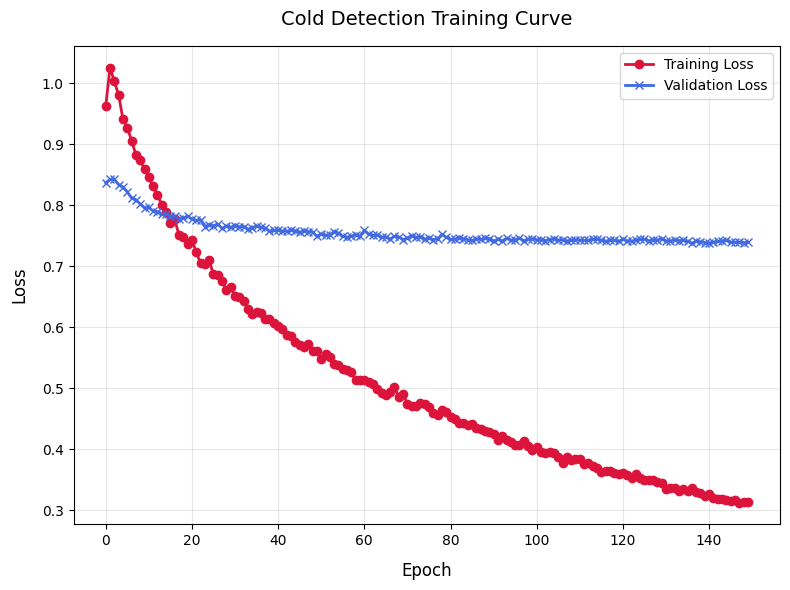

In [305]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(8, 6))
plt.plot(training_losses, label='Training Loss', color='crimson', marker='o', linewidth=2, markersize=6)
plt.plot(validation_losses, label='Validation Loss', color='royalblue', marker='x', linewidth=2, markersize=6)

plt.title('Cold Detection Training Curve', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

print(f"✅ Epochs completed: {len(training_losses)} / Defined: {num_epochs}")

loss_df = pd.DataFrame({
    "epoch": list(range(1, len(training_losses) + 1)),
    "training_loss": training_losses,
    "validation_loss": validation_losses
})
loss_df.to_csv("cold_training_loss.csv", index=False)
print("📁 Saved loss curve and CSV")


In [306]:
from sklearn.metrics import recall_score
val_preds = []
val_labels = []
val_probs = []
model.eval()
with torch.no_grad():
    for X, y in val_loader:
        logits = model(X.to(device)).squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.7).long()
        val_probs.extend(probs.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(y.numpy())


# 计算UAR (Unweighted Average Recall)
uar = recall_score(val_labels, val_preds, average='macro')
print(f"Validation UAR: {uar:.4f}")

# 可选：同时显示每个类别的召回率
if len(set(val_labels)) > 1 and len(set(val_preds)) > 1:
    class_recalls = recall_score(val_labels, val_preds, average=None)
    print(f"Class 0 (Healthy) Recall: {class_recalls[0]:.4f}")
    print(f"Class 1 (Cold) Recall: {class_recalls[1]:.4f}")

Validation UAR: 0.5825
Class 0 (Healthy) Recall: 0.9612
Class 1 (Cold) Recall: 0.2038


预测分布: {np.int64(0): 5664, np.int64(1): 402}
真实标签分布: {np.int64(0): 5055, np.int64(1): 1011}


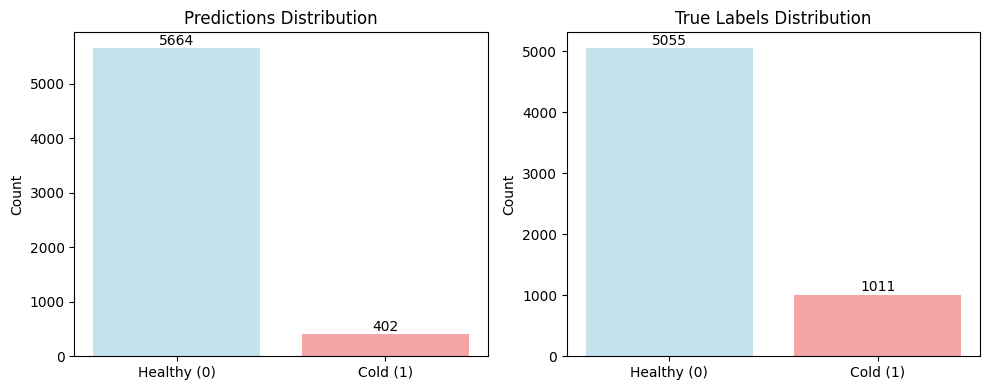


总样本数: 6066
预测为Healthy: 5664 (93.4%)
预测为Cold: 402 (6.6%)
实际Healthy: 5055 (83.3%)
实际Cold: 1011 (16.7%)


In [307]:
# 📊 简单的预测vs标签分布可视化
import matplotlib.pyplot as plt
from collections import Counter

# 统计分布
pred_counts = Counter(val_preds)
label_counts = Counter(val_labels)

print(f"预测分布: {dict(pred_counts)}")
print(f"真实标签分布: {dict(label_counts)}")

# 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# 预测分布
categories = ['Healthy (0)', 'Cold (1)']
pred_values = [pred_counts.get(0, 0), pred_counts.get(1, 0)]
ax1.bar(categories, pred_values, color=['lightblue', 'lightcoral'], alpha=0.7)
ax1.set_title('Predictions Distribution')
ax1.set_ylabel('Count')
for i, v in enumerate(pred_values):
    ax1.text(i, v + max(pred_values)*0.01, str(v), ha='center')

# 真实标签分布  
label_values = [label_counts.get(0, 0), label_counts.get(1, 0)]
ax2.bar(categories, label_values, color=['lightblue', 'lightcoral'], alpha=0.7)
ax2.set_title('True Labels Distribution')
ax2.set_ylabel('Count')
for i, v in enumerate(label_values):
    ax2.text(i, v + max(label_values)*0.01, str(v), ha='center')

plt.tight_layout()
plt.show()

# 简单统计
total = len(val_preds)
print(f"\n总样本数: {total}")
print(f"预测为Healthy: {pred_counts.get(0, 0)} ({pred_counts.get(0, 0)/total:.1%})")
print(f"预测为Cold: {pred_counts.get(1, 0)} ({pred_counts.get(1, 0)/total:.1%})")
print(f"实际Healthy: {label_counts.get(0, 0)} ({label_counts.get(0, 0)/total:.1%})")  
print(f"实际Cold: {label_counts.get(1, 0)} ({label_counts.get(1, 0)/total:.1%})")

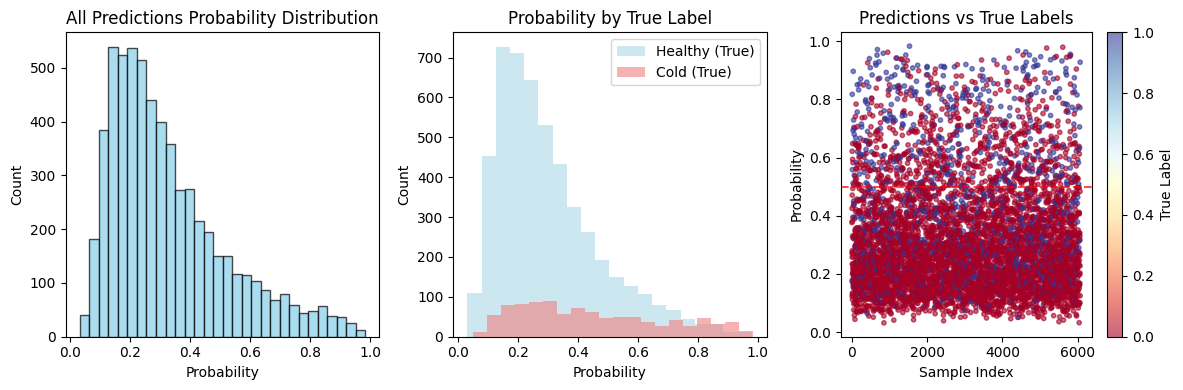

概率分布统计:
平均概率: 0.3271
概率标准差: 0.1947
最小概率: 0.0318
最大概率: 0.9832

Healthy样本平均概率: 0.3024
Cold样本平均概率: 0.4504


In [308]:
# 🎯 简单的概率分布可视化
import matplotlib.pyplot as plt
import numpy as np

# 确保val_probs已经收集完成
val_probs = np.array(val_probs)
val_labels = np.array(val_labels)

# 1. 概率分布直方图
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(val_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('All Predictions Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')

# 2. 按真实标签分别显示概率分布
plt.subplot(1, 3, 2)
healthy_probs = val_probs[val_labels == 0]
cold_probs = val_probs[val_labels == 1]

plt.hist(healthy_probs, bins=20, alpha=0.6, label='Healthy (True)', color='lightblue')
plt.hist(cold_probs, bins=20, alpha=0.6, label='Cold (True)', color='lightcoral')
plt.title('Probability by True Label')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()

# 3. 概率vs标签散点图
plt.subplot(1, 3, 3)
plt.scatter(range(len(val_probs)), val_probs, c=val_labels, 
           cmap='RdYlBu', alpha=0.6, s=10)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
plt.title('Predictions vs True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.colorbar(label='True Label')

plt.tight_layout()
plt.show()

# 4. 简单统计
print("=" * 40)
print("概率分布统计:")
print("=" * 40)
print(f"平均概率: {val_probs.mean():.4f}")
print(f"概率标准差: {val_probs.std():.4f}")
print(f"最小概率: {val_probs.min():.4f}")
print(f"最大概率: {val_probs.max():.4f}")

print(f"\nHealthy样本平均概率: {healthy_probs.mean():.4f}")
print(f"Cold样本平均概率: {cold_probs.mean():.4f}")

In [310]:
import numpy as np
from sklearn.metrics import f1_score

probs = []   # 在完整的验证集上收集 sigmoid(logits)
labels = []

model.eval()
with torch.no_grad():
    for X,y in val_loader:
        logits = model(X.to(device)).squeeze()
        p = torch.sigmoid(logits).cpu().numpy()
        probs.extend(p)
        labels.extend(y.numpy())

probs = np.array(probs)
labels = np.array(labels)

best_t, best_f1 = 0.5, 0
for t in np.linspace(0.1, 0.9, 81):
    preds = (probs > t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"最佳阈值 = {best_t:.2f}, 对应 F1 = {best_f1:.3f}")


最佳阈值 = 0.44, 对应 F1 = 0.377


## Test Set

In [309]:
from sklearn.metrics import accuracy_score, f1_score

print("\n🚀 Starting testing...")
model.eval()

clusters_txt = "./clusters_8.txt"
test_dataset = ColdDetectionDataset(
                    test_embeddings_dict, 
                    label_dict,
                    label_ratio=100
                )

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


test_preds = []
test_labels = []

with torch.no_grad():
    with tqdm(total=len(test_loader.dataset),
              desc="Testing",
              unit="samples",
              ncols=100) as progress_bar:
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X).squeeze() 
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).long()

            test_preds.extend(preds.cpu().tolist())
            test_labels.extend(batch_y.cpu().tolist())

            progress_bar.update(batch_X.size(0))

acc = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print(f"\n✅ Test Accuracy: {acc:.4f}")
print(f"✅ Test F1 Score: {f1:.4f}")



🚀 Starting testing...


Testing: 100%|██████████████████████████████████████████| 9596/9596 [00:00<00:00, 19183.38samples/s]


✅ Test Accuracy: 0.8464
✅ Test F1 Score: 0.3041


In [312]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import numpy as np

# ...existing code...

# 计算UAR (Unweighted Average Recall)
uar = recall_score(test_labels, test_preds, average='macro')

print(f"\n📈 PERFORMANCE METRICS:")
print(f"   Accuracy: {acc:.4f}")
print(f"   F1 Score: {f1:.4f}")
print(f"   UAR (Unweighted Average Recall): {uar:.4f}")

if len(set(test_labels)) > 1 and len(set(test_preds)) > 1:
    cm = confusion_matrix(test_labels, test_preds)
    
    class_recalls = []
    for i in range(len(cm)):
        if cm[i].sum() > 0:  
            recall = cm[i, i] / cm[i].sum()
            class_recalls.append(recall)
        else:
            class_recalls.append(0.0)
    
    print(f"\n🎯 PER-CLASS RECALL:")
    class_names = ['Healthy', 'Cold']
    for i, (name, recall) in enumerate(zip(class_names, class_recalls)):
        print(f"   Class {i} ({name}): {recall:.4f}")
    
    manual_uar = np.mean(class_recalls)
    print(f"\n✅ UAR Verification:")
    print(f"   sklearn UAR: {uar:.4f}")
    print(f"   Manual UAR:  {manual_uar:.4f}")
    print(f"   Match: {'✓' if abs(uar - manual_uar) < 0.0001 else '✗'}")



📈 PERFORMANCE METRICS:
   Accuracy: 0.8464
   F1 Score: 0.0873
   UAR (Unweighted Average Recall): 0.6135

🎯 PER-CLASS RECALL:
   Class 0 (Healthy): 0.9086
   Class 1 (Cold): 0.3185

✅ UAR Verification:
   sklearn UAR: 0.6135
   Manual UAR:  0.6135
   Match: ✓
